In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip "/content/EuroSAT.zip"

Streaming output truncated to the last 5000 lines.
  inflating: 2750/SeaLake/SeaLake_2206.jpg  
  inflating: 2750/SeaLake/SeaLake_1313.jpg  
  inflating: 2750/SeaLake/SeaLake_263.jpg  
  inflating: 2750/SeaLake/SeaLake_967.jpg  
  inflating: 2750/SeaLake/SeaLake_515.jpg  
  inflating: 2750/SeaLake/SeaLake_1465.jpg  
  inflating: 2750/SeaLake/SeaLake_1817.jpg  
  inflating: 2750/SeaLake/SeaLake_2902.jpg  
  inflating: 2750/SeaLake/SeaLake_2570.jpg  
  inflating: 2750/SeaLake/SeaLake_1004.jpg  
  inflating: 2750/SeaLake/SeaLake_174.jpg  
  inflating: 2750/SeaLake/SeaLake_2111.jpg  
  inflating: 2750/SeaLake/SeaLake_2388.jpg  
  inflating: 2750/SeaLake/SeaLake_1948.jpg  
  inflating: 2750/SeaLake/SeaLake_838.jpg  
  inflating: 2750/SeaLake/SeaLake_2738.jpg  
  inflating: 2750/SeaLake/SeaLake_1999.jpg  
  inflating: 2750/SeaLake/SeaLake_2359.jpg  
  inflating: 2750/SeaLake/SeaLake_2660.jpg  
  inflating: 2750/SeaLake/SeaLake_1775.jpg  
  inflating: 2750/SeaLake/SeaLake_605.jpg  
  inflatin

# Image classification with Vision Transformer

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/18<br>
**Last modified:** 2021/01/18<br>
**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Introduction

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929)
model by Alexey Dosovitskiy et al. for image classification,
and demonstrates it on the CIFAR-100 dataset.
The ViT model applies the Transformer architecture with self-attention to sequences of
image patches, without using convolution layers.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```python
pip install -U tensorflow-addons
```

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.7 MB/s 


In [ ]:
from skimage import io

In [ ]:
#for multispectral
import os
from skimage import io
from skimage import img_as_ubyte, img_as_float32
import numpy as np
images_train=[]
labels_train=[]
images_val=[]
labels_val=[]
images_test=[]
labels_test=[]
path="copy data path "
for i,j in enumerate(sorted(os.listdir(path))):   
    new_path=os.path.join(path,j)
    for p,k in enumerate(os.listdir(new_path)):
        if p==2000:
            break
        npath = os.path.join(new_path,k)
        image=io.imread(npath)
        im=img_as_ubyte(image)
        if p<1400:
            images_train.append(im)
            labels_train.append(i)
                
        elif  p>=1400 and p<1600:
            images_val.append(im)
            labels_val.append(i)            
        else :
            images_test.append(im)
            labels_test.append(i)

In [ ]:
len(labels_test)

4000

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


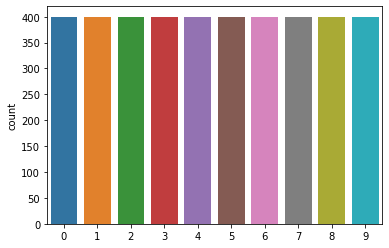

In [ ]:
import seaborn as sns 
sns.countplot(labels_test)

In [ ]:
images_train=np.array(images_train)
labels_train=np.array(labels_train)
images_val=np.array(images_val)
labels_val=np.array(labels_val)
images_test=np.array(images_test)
labels_test=np.array(labels_test)


## Setup

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

## Prepare the data

In [ ]:
num_classes = 10
input_shape = (64, 64 ,13)
images_train[0].shape


(64, 64, 4)

## Configure the hyperparameters
## chnage one parameter at a time and run all the cells below
## change patch size to 6,9
## change num_heads to 6,7
## change transformer_layers to 6,10

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(images_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(10)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )


    history = model.fit(
        x=images_train,
        y=labels_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(images_val,labels_val),
        #callbacks=[checkpoint_callback],
    )

    print(model.evaluate(images_test,labels_test))
    return history,model



vit_classifier = create_vit_classifier()
history,model = run_experiment(vit_classifier)


Epoch 1/100


ResourceExhaustedError: ignored

In [ ]:
model.evaluate(images_test,labels_test)

## run the below cells if the results are better


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'down right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


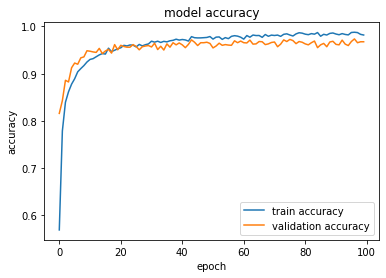

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label="train accuracy")
plt.plot(history.history['val_accuracy'],label="validation accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="down right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'down right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


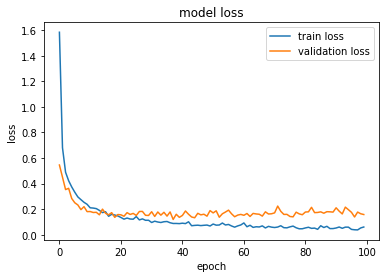

In [ ]:
plt.plot(history.history['loss'],label="train loss")
plt.plot(history.history['val_loss'],label="validation loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc="down right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

After 100 epochs, the ViT model achieves around 55% accuracy and
82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset,
as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the
[paper](https://arxiv.org/abs/2010.11929) are achieved by pre-training the ViT model using
the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality
without pre-training, you can try to train the model for more epochs, use a larger number of
Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. 
Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, 
but also by parameters such as the learning rate schedule, optimizer, weight decay, etc.
In practice, it's recommended to fine-tune a ViT model
that was pre-trained using a large, high-resolution dataset.

In [ ]:
predictions=model.predict(images_test).argmax(axis=1)

In [ ]:
print(classification_report(labels_test,predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       400
           1       0.98      0.99      0.99       400
           2       0.98      0.96      0.97       400
           3       0.93      0.90      0.92       400
           4       0.95      0.98      0.96       400
           5       0.96      0.96      0.96       400
           6       0.97      0.94      0.96       400
           7       0.95      0.97      0.96       400
           8       0.98      0.98      0.98       400
           9       1.00      1.00      1.00       400

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



[0.97, 0.96, 0.97]
[0.98, 0.99, 0.99]
[0.98, 0.96, 0.97]
[0.93, 0.9, 0.92]
[0.95, 0.98, 0.96]
[0.96, 0.96, 0.96]
[0.97, 0.94, 0.96]
[0.95, 0.97, 0.96]
[0.98, 0.98, 0.98]
[1.0, 1.0, 1.0]
plotMat: [[0.97, 0.96, 0.97], [0.98, 0.99, 0.99], [0.98, 0.96, 0.97], [0.93, 0.9, 0.92], [0.95, 0.98, 0.96], [0.96, 0.96, 0.96], [0.97, 0.94, 0.96], [0.95, 0.97, 0.96], [0.98, 0.98, 0.98], [1.0, 1.0, 1.0]]
support: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


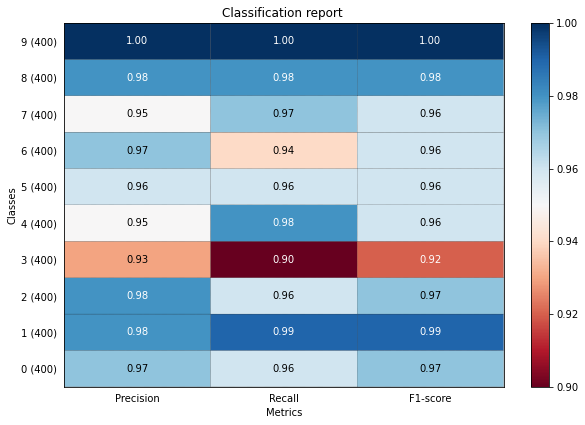

In [ ]:
import matplotlib.pyplot as plt
#for rgb
def show_values(pc, fmt="%.2f", **kw):

    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):

    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()      

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):

    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():

    sampleClassificationReport = """    precision    recall  f1-score   support

           0       0.97      0.96      0.97       400
           1       0.98      0.99      0.99       400
           2       0.98      0.96      0.97       400
           3       0.93      0.90      0.92       400
           4       0.95      0.98      0.96       400
           5       0.96      0.96      0.96       400
           6       0.97      0.94      0.96       400
           7       0.95      0.97      0.96       400
           8       0.98      0.98      0.98       400
           9       1.00      1.00      1.00       400

    accuracy                           0.97      4000
    macro avg       0.97      0.97      0.97      4000
    weighted avg       0.97      0.97      0.97      4000
    """
    plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.savefig('./test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()


[0.96, 0.84, 0.89]
[0.98, 0.98, 0.98]
[0.9, 0.93, 0.92]
[0.89, 0.89, 0.89]
[0.97, 0.93, 0.95]
[0.89, 0.92, 0.9]
[0.84, 0.92, 0.88]
[0.93, 0.98, 0.96]
[0.91, 0.91, 0.91]
[0.98, 0.96, 0.97]
plotMat: [[0.96, 0.84, 0.89], [0.98, 0.98, 0.98], [0.9, 0.93, 0.92], [0.89, 0.89, 0.89], [0.97, 0.93, 0.95], [0.89, 0.92, 0.9], [0.84, 0.92, 0.88], [0.93, 0.98, 0.96], [0.91, 0.91, 0.91], [0.98, 0.96, 0.97]]
support: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


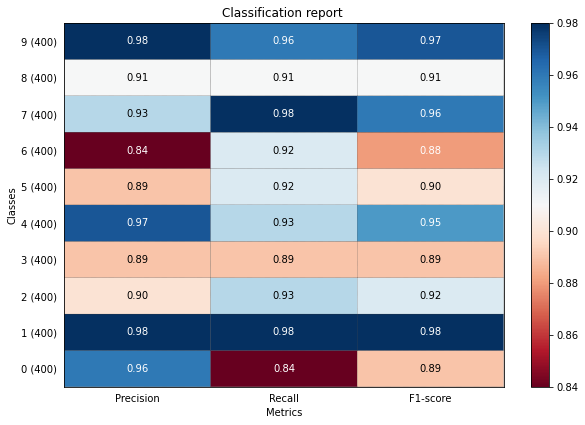

In [ ]:
import matplotlib.pyplot as plt
#for rgb
def show_values(pc, fmt="%.2f", **kw):

    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):

    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()      

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):

    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():

    sampleClassificationReport = """    precision    recall  f1-score   support

           0       0.96      0.84      0.89       400
           1       0.98      0.98      0.98       400
           2       0.90      0.93      0.92       400
           3       0.89      0.89      0.89       400
           4       0.97      0.93      0.95       400
           5       0.89      0.92      0.90       400
           6       0.84      0.92      0.88       400
           7       0.93      0.98      0.96       400
           8       0.91      0.91      0.91       400
           9       0.98      0.96      0.97       400

    accuracy                           0.92      4000
    macro avg       0.93      0.92      0.92      4000
    weighted avg       0.93      0.92      0.92      4000
    """
    plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.savefig('./test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()


[0.99, 0.83, 0.9]
[0.97, 0.98, 0.97]
[0.93, 0.93, 0.93]
[0.92, 0.89, 0.9]
[0.96, 0.95, 0.96]
[0.92, 0.9, 0.91]
[0.84, 0.91, 0.88]
[0.89, 0.99, 0.94]
[0.98, 0.98, 0.98]
[0.99, 0.99, 0.99]
plotMat: [[0.99, 0.83, 0.9], [0.97, 0.98, 0.97], [0.93, 0.93, 0.93], [0.92, 0.89, 0.9], [0.96, 0.95, 0.96], [0.92, 0.9, 0.91], [0.84, 0.91, 0.88], [0.89, 0.99, 0.94], [0.98, 0.98, 0.98], [0.99, 0.99, 0.99]]
support: [400, 400, 400, 400, 400, 400, 400, 400, 400, 400]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


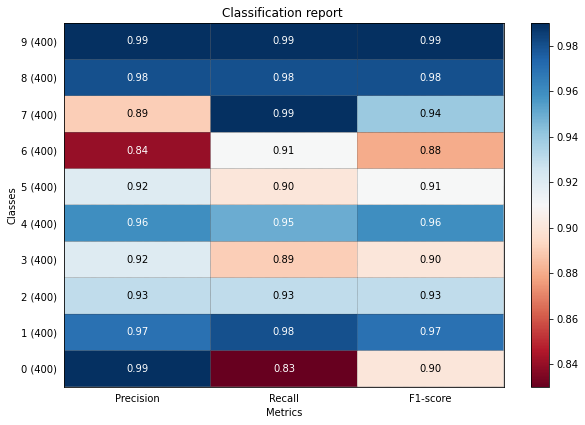

In [ ]:
#for rgb+ nir
import matplotlib.pyplot as plt
#for rgb
def show_values(pc, fmt="%.2f", **kw):

    pc.update_scalarmappable()
    ax = pc.axes
    #ax = pc.axes# FOR LATEST MATPLOTLIB
    #Use zip BELOW IN PYTHON 3
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):

    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()      

    # resize
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):

    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []

    for line in lines[2 : (len(lines) - 4)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)


def main():

    sampleClassificationReport = """     precision    recall  f1-score   support

           0       0.99      0.83      0.90       400
           1       0.97      0.98      0.97       400
           2       0.93      0.93      0.93       400
           3       0.92      0.89      0.90       400
           4       0.96      0.95      0.96       400
           5       0.92      0.90      0.91       400
           6       0.84      0.91      0.88       400
           7       0.89      0.99      0.94       400
           8       0.98      0.98      0.98       400
           9       0.99      0.99      0.99       400

    accuracy                           0.94      4000
    macro avg       0.94      0.94      0.94      4000
    weighted avg       0.94      0.94      0.94      4000
    """
    plot_classification_report(sampleClassificationReport)
    plt.show()
    plt.savefig('./test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
    plt.close()

if __name__ == "__main__":
    main()


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np
cm=confusion_matrix(labels_test,predictions)
def plot_confusion_matrix_2(cm,
                      target_names,
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True):
    FONT_SIZE = 8

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8*2, 6*2))    # 8, 6
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90, fontsize=FONT_SIZE)
        plt.yticks(tick_marks, target_names, fontsize=FONT_SIZE)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=FONT_SIZE,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=FONT_SIZE,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

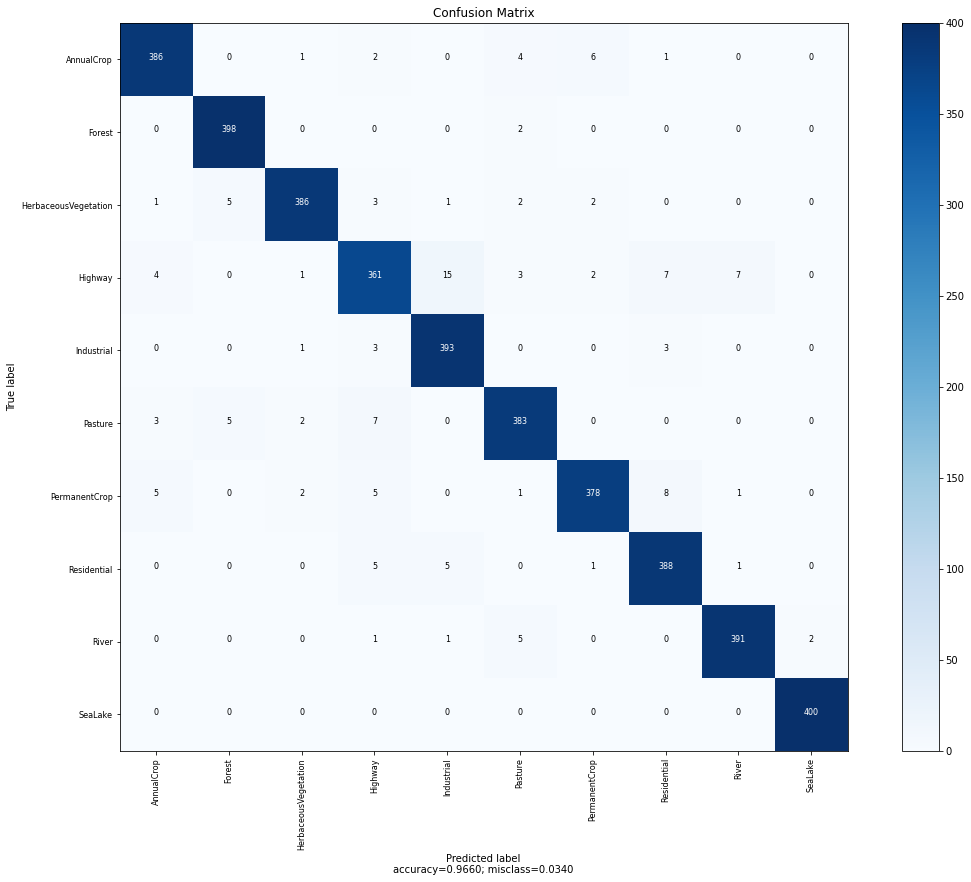

In [ ]:
plot_confusion_matrix_2(cm, sorted(os.listdir("/content/drive/Othercomputers/My Laptop/EuroSATallBands/ds/images/remote_sensing/otherDatasets/sentinel_2/tif")), normalize=False, title='Confusion Matrix')